# WIPRO TIME SERIERS - ANOMALY DETECTION AND SEQUENCE PREDICTION

**Requirements**

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

USE_CUDA = torch.cuda.is_available()

env: CUDA_VISIBLE_DEVICES=0


# Load NASA data 

[from dataset readme]
The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1)  unit number  
2)  time, in cycles  
3)  operational setting 1  
4)  operational setting 2  
5)  operational setting 3  
6)  sensor measurement  1  
7)  sensor measurement  2  
...  
26) sensor measurement  26  


In [2]:
file_path = '/home/hillel/projects/time_series/nasa_data/train_FD001.txt'
header_names = ['unit number', 'time in cycles']  + ['operational setting %d'%i for i in range(1, 4)] + [ 'sensor measurement %d'%i for i in range(1, 24)]
df = pd.read_csv(file_path, sep=' ', header=None, names=header_names)
df = df.dropna(axis=1, how='all')
df.head()

,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
def get_train_test_data(df):
    
    amount_of_units_tot = df['unit number'].max()
    amount_of_units_tst = 2
    amunt_of_units_tr = amount_of_units_tot - amount_of_units_tst

    test_units = np.random.choice(range(1, amount_of_units_tot+1), amount_of_units_tst)
    train_units = [i for i in range(1, amount_of_units_tot + 1) if i not in test_units]

    X_tr = []
    X_tst = []

    for idx in range(1, amount_of_units_tot + 1):
        group_np = df[df['unit number'] == idx].iloc[:, 1:-1].as_matrix()
        me = np.mean(group_np, axis=0)
        std = np.std(group_np, axis=0)
        group_np_norm = (group_np - me) / (std + 1e-12)
        if idx in test_units:
            X_tst.append(group_np_norm)
        elif idx in train_units:
            X_tr.append(group_np_norm)
        else:
            raise Exception("bad index %d ??"%idx)
    return X_tr, X_tst

#  Recurrent anttention based model

The idea being learn the sequential dependencys and structure via gated rnn,
and to learn spatial structure and similarity via attention mechanism. 

The Attention used in this case is inspired by https://arxiv.org/pdf/1508.04025.pdf
Where the context vector is appended to final hiddent state and are passed to output layer.
This differs to the standerd case where context is appended to input of the reccurent cell.

The RNN sequence is inspired by https://arxiv.org/pdf/1308.0850.pdf
Where LSTM based models are used for pedicting next time step.

The code is mostly based on code found here:
http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [4]:
class TrainBatch():
    
    def __init__(self, data, batch_sz, window_sz):
        self._data = data
        self._batch_sz = batch_sz
        self._window_sz = window_sz
        self._input_sz = data[0].shape[-1]
        self._seq_len = [x.shape[0] for x in self._data]
        self._curr_batch = None
        
    def next_batch(self):
        """
        return:batch[(batch_size,seq_len,input_size)]
        """
        batch = np.empty(shape=[self._batch_sz, self._window_sz, self._input_sz]) 
        amount_of_units = len(self._data)
        choose_units = np.random.choice(amount_of_units, self._window_sz)
    
        for id, unit_id in zip(range(self._batch_sz), choose_units):
            w_start_id = np.random.randint(0, self._seq_len[unit_id] - self._window_sz)
            unit = self._data[unit_id][w_start_id:w_start_id+self._window_sz, :] # for unit get seq of window sz
            batch[id,...] = unit
        batch = Variable(torch.from_numpy(batch.astype('float32')), requires_grad=False)
        if USE_CUDA:
            batch = batch.cuda()
        self._curr_data = batch
        
        return batch   

** Recurrent model for capturing sequential information**

In [5]:
class SequencePredRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(SequencePredRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=False)

    def forward(self, inputs, hidden):
        output = inputs
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

** Attention model utilize reccurnt ouputs and their spatial similarity for predicting next time step**

In [6]:
class AttendAndPredict(nn.Module):
    """Attention nn module that is responsible for computing the alignment scores."""

    def __init__(self, method, hidden_size, output_size):
        super(AttendAndPredict, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Define layers
        if self.method == 'general':
            self.attention = nn.Linear(self.hidden_size, self.hidden_size)
        elif self.method == 'concat':
            self.attention = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, self.hidden_size))
            
        self.fc_out = nn.Linear(self.hidden_size * 2, self.output_size)
        
        

    def forward(self, hidden, M):
        """Attend over N rnn sequence prediction outputs till time t-1 (t-2-N...t-1).
        
        After creating variables to store the attention energies, calculate their 
        values for each encoder output and return the normalized values.
        
        Args:
            M(mem_size,batch,input size): memory of which to attend over.
            hidden(1, batch, input size): hidden state.
            
        Returns:
             Normalized (0..1) energy values, re-sized to 1 x 1 x seq_len
        """
        
        mem_size = M.size()[0]
        batch_size = M.size()[1]
        
        # convert to batch first
        M = M.permute(1,0,2)
        hidden = hidden.permute(1,2,0)

        energies = self._score(hidden, M)
        a = F.softmax(energies)
        c = a.permute(0,2,1).bmm(M)
        next_timestep_prediction = self.fc_out(torch.cat((c.squeeze(1), hidden.squeeze(2)), 1))
        
        return next_timestep_prediction, a
        
    def _score(self, hidden, M):
        """
        Calculate the relevance of a particular encoder output in respect to the decoder hidden.
        Args:
            hidden: decoder hidden output used for condition.
            M(batch,seq_len,input_size): memory of which to attend over.
            hidden(1, batch, input size): hidden state.
        """

        if self.method == 'dot':
            # TODO: Not tested
            energy = hidden.dot(M)
        elif self.method == 'general':
            energy = self.attention(M)
            energy = torch.bmm(energy, hidden)#hidden.dot(energy)
        elif self.method == 'concat':
            # TODO: Not tested
            energy = self.attention(torch.cat((hidden, M), 1))
            energy = self.other.dor(energy)
        return energy



In [7]:
class SeqRnnAttnAndPred(nn.Module):
    """
    SequenceAttnPred - Recurrent Atteniton based model for predicting next time step.
    """
    def __init__(self, input_size, hidden_size, output_size, batch_size,
                 rnn_layers=1, atnn_method='general', memory_size=-1):
        """
        args:
        input_size: size of elemnt of sequnece.
        hidden_size: size of hidden state of RNN (same as output if only 1 RNN).
        output_size: size of output tensor.
        rnn_layers: amount of stacked RNN's (see any basic seq2seq paper).
        atnn_method: type of attention to use.
        memory_size: amount of rnn output's to aggregate and attend over.
        """
        super(SeqRnnAttnAndPred, self).__init__()
        self._rnn_layer = SequencePredRNN(input_size, hidden_size, rnn_layers)
        self._atnn_layer = AttendAndPredict(atnn_method, hidden_size, output_size)
        self._memory_size = memory_size
        self._batch_size = batch_size
        
    def forward(self, inputs, hidden):
        """
        args:
        inputs(seq_len,batch,input_len): input sequence predict seq_len + 1
        """
        seq_len = inputs.size()[0]
        
        # in case of 1 rnn layer output == hidden.
        seqrnn_output, hidden = self._rnn_layer(inputs, hidden)
        self.memory = seqrnn_output[-self._memory_size-1:-1]
        hidden_t = seqrnn_output[-1].unsqueeze(0)
        outputs, alignment = self._atnn_layer(hidden_t, self.memory)
        return outputs, alignment
    
    def init_hidden(self):
        hidden = Variable(torch.zeros(1, self._batch_size, self._rnn_layer.hidden_size))
        hidden = hidden.cuda() if USE_CUDA else hidden
        return hidden
        
   

** Helper functions **

In [8]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

** Training procedure**

Run model on data

In [9]:
def run(input_seq, model, criterion, train=False, optimizer=None):
    """
    Train for a given sequence batch size.
    Args:
    input_seq(batch_size,seq_len,input_size): tensor containin sequences.
    model: input model - batch is first dim.
    criterion: distance measure i.e. l1, l2 etc.
    optimizer: GD, ADAM etc.
    """ 
    input_seq = input_seq.transpose(0, 1)
    hidden = model.init_hidden()
    preds, alignment = model(input_seq[:-1], hidden)
    loss = criterion(preds, input_seq[-1])
    
    if train:
        model.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss.data[0], preds
        


This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

Full train procedure

In [10]:
def trainIters(train_batch, model, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss().cuda()
  

    for iter in range(1, n_iters):
        
        curr_batch = train_batch.next_batch()
        
        loss, _ = run(curr_batch, model, criterion, True, optimizer)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, float(iter) / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    show_plot(plot_losses)


In [11]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [12]:
def evaluate(test_data, model):
    
    loss_total = 0  # Reset every print_every
    test_count = 0
    window_len = 30
    criterion = nn.MSELoss().cuda()
    
    for seq in test_data:
        seq_len = seq.shape[0]
        for i in range(seq_len - window_len):
            test_seq = seq[i: i + window_len]
            test_seq = Variable(torch.from_numpy(test_seq.astype('float32')), requires_grad=False).unsqueeze(0)
            if USE_CUDA:
                test_seq = test_seq.cuda()
            loss, _ = run(test_seq, model, criterion, False)
            loss_total += loss
            test_count += 1
    print("total test error %.4f"%(float(loss_total)/test_count))
    

** Main Entry Point **

train size: 98 test size: 2
0m 31s (- 51m 16s) (5000 0%) 0.1674
1m 2s (- 50m 39s) (10000 0%) 0.1424
1m 33s (- 50m 19s) (15000 0%) 0.1406
2m 4s (- 49m 41s) (20000 0%) 0.1404
2m 35s (- 49m 11s) (25000 0%) 0.1398
3m 6s (- 48m 39s) (30000 0%) 0.1391
3m 37s (- 48m 4s) (35000 0%) 0.1388
4m 8s (- 47m 36s) (40000 0%) 0.1387
4m 39s (- 47m 7s) (45000 0%) 0.1381
5m 10s (- 46m 38s) (50000 0%) 0.1380
5m 42s (- 46m 13s) (55000 0%) 0.1379
6m 14s (- 45m 49s) (60000 0%) 0.1381
6m 47s (- 45m 24s) (65000 0%) 0.1380
7m 19s (- 44m 59s) (70000 0%) 0.1380
7m 51s (- 44m 32s) (75000 0%) 0.1375
8m 23s (- 44m 4s) (80000 0%) 0.1374
8m 55s (- 43m 34s) (85000 0%) 0.1372
9m 28s (- 43m 7s) (90000 0%) 0.1377
9m 59s (- 42m 37s) (95000 0%) 0.1369
10m 32s (- 42m 8s) (100000 0%) 0.1373
11m 4s (- 41m 39s) (105000 0%) 0.1369
11m 36s (- 41m 10s) (110000 0%) 0.1367
12m 9s (- 40m 41s) (115000 0%) 0.1374
12m 41s (- 40m 11s) (120000 0%) 0.1369
13m 14s (- 39m 42s) (125000 0%) 0.1366
13m 46s (- 39m 12s) (130000 0%) 0.1366
14m 18s 

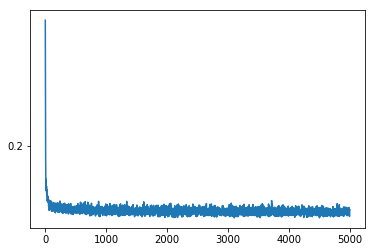

In [13]:
data_train, data_test = get_train_test_data(df)
print("train size: %d test size: %d"%(len(data_train), len(data_test)))
input_size = data_train[0].shape[-1]
output_size = input_size
batch_size = 64
hidden_size = input_size # disregarded when rnn_layers=1
rnn_layers = 1
memory_size = 15
window_size = 30 # what is the window we train over

model = SeqRnnAttnAndPred(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
                          batch_size=batch_size, rnn_layers=rnn_layers, atnn_method='general',
                          memory_size=memory_size)

if USE_CUDA:
    model = model.cuda()
    
train_batch = TrainBatch(data_train, batch_size, window_size)

trainIters(train_batch, model, 500000, print_every=5000)

torch.save(model.state_dict(), "./saved_models/pred_nasa_seq")

In [14]:
data_test[0].shape

(158, 24)

** Run Evaluation **

In [15]:
model = SeqRnnAttnAndPred(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
                          batch_size=1, rnn_layers=rnn_layers, atnn_method='general',
                          memory_size=memory_size)
if USE_CUDA:
    model = model.cuda()
    
model.load_state_dict(torch.load("./saved_models/pred_nasa_seq"))


evaluate(data_test, model)

total test error 55.1508
